# **Classificazione dei prodotti di Scattering Elettrone-Protone**

Confronto tra diversi modelli di *apprendimento supervisionato* per la *classificazione* di particelle prodotte durante uno scattering inelastico elettrone-protone basato sulla risposta di sei diversi rilevatori. L'obiettivo è quello di identificare le particelle e valutare il migliore modello tra i seguenti:

- **Decision Tree**
- **Random Forest**
- **Multilayer Perceptron**
- **K-Nearest Neighbor**

I dati utilizzati sono il prodotto della risposta di sei diversi rilevatori mediante la piattaforma di simulazione *[GEANT4](https://geant4.web.cern.ch/)*. Il DataSet è reperibile su *[Kaggle](https://www.kaggle.com/datasets/naharrison/particle-identification-from-detector-responses)*.

## **Analisi Esplorativa & Preparazione dei Dati**

Importo i moduli e le librerie di interesse, utili per l'analisi del dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Carico il dataset in locale.

In [2]:
df = pd.read_csv("..\GEANT4_Simulation.csv")
df.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


Per una maggiore leggibilità rinomino la colonna **id** e **nphe**.

Inoltre sostituisco il *codice* associato a ciascuna particella con il suo **nome** rimappando i valori. Per tale operazione uso il metodo [`dict.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html).

In [3]:
# Dizionario contente l'associazione chiave valore id:nome

dictParticelle = { -11 : 'positrone',
                  211 : 'pione',
                  321 : 'kaone',
                  2212 : 'protone'}

**Composizione DataSet**

|    Features    |              Significato              | Unità di Misura |
| :-------------: | :------------------------------------: | :--------------: |
|  **id**  |            Nome Particella            |    $NoDim$    |
|   **p**   |           Quantità di moto           |    $GeV/c$    |
| **theta** |          Angolo di Scattering          |     $rad$     |
| **beta** | Rapporto tra la velocità $v$ e $c$ |    $NoDim$    |
| **nphe** |        Numero di fotoelettroni        |    $NoDim$    |
|  **ein**  |          Energia in ingresso          |     $GeV$     |
| **eout** |           Energia in uscita           |     $GeV$     |


**Valore Particelle**

|    id    |              Particella              | Simbolo |        Massa (MeV)   |  
| :-------------: | :------------------------------------: | :--------------: | :--------: |
|  **(-11)**  |            Positrone            |    $e^+$    | $0.51$ |
|   **(211)**   |           Pione           |    $\pi \quad (\pi^0,\pi^+,\pi^-)$    | $133$ |
| **(321)** |          Kaone          |     $K \quad (K^0,K^+,K^-)$      | $495$ |
| **(2212)** | Protone |     $p$     | $940$ |


In [4]:
# Rinomino le colonne 'id' e 'nphe'
df.rename(columns={'id' : 'particella'}, inplace=True)
df.rename(columns={'nphe' : 'elettroni'}, inplace=True)

# Rimappo i valori della colonna 'particella'
df['particella'] = df['particella'].map(dictParticelle)

In [5]:
df.head(10)

,particella,p,theta,beta,elettroni,ein,eout
0,pione,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,pione,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,protone,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,pione,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,protone,2.123290,0.337332,0.908652,0,0.034379,0.049256
5,pione,0.403296,0.694215,0.958553,0,0.000000,0.000000
6,protone,1.382620,0.436689,0.844835,0,0.200275,0.053651
7,protone,1.133130,0.276831,0.781295,0,0.044038,0.093980
8,protone,0.656291,0.542507,0.560291,0,0.083406,0.000000
9,protone,2.077210,0.130479,0.909951,0,0.036164,0.045960


Controllo adesso se per qualche particella mancano delle feature e verifico la dimensionalità del dataframe. Per farlo uso [`pd.DataFrame.isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html) e [`pd.DataFrame.sum()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html).

In [6]:
print(df.isnull().sum())
print("-"*20)
print(df.shape)

particella    0
p             0
theta         0
beta          0
elettroni     0
ein           0
eout          0
dtype: int64
--------------------
(5000000, 7)


Ci sono cinque milioni di particelle, ciascuna con sei features e nessun dato è mancante.

Osservando il dataset ipotizzo che il rilevatore circa gli *elettroni* è stato **inneficiente** (segna spesso 0). Verifico questa ipotosi ed eventualmente elimino la colonna prima dell'addestramento dei modelli.

In [7]:
flop = df['elettroni'].value_counts(normalize = True)
print('Il rilevatore manca il segnale il {volte:.2%} delle volte'.format(volte=flop[0]))

Il rilevatore manca il segnale il 93.52% delle volte


Pertanto posso eliminare la feature **elettroni**, in quanto non significativa.

In [8]:
df.drop(columns = ['elettroni'], inplace=True)

Inoltre posso rimuovere anche quei dati **fisicamente non coerenti** dovuti a un'inefficienza dei detector o errori di tipo statistico, eliminando tutte quelle particelle che superano il valore di threshold:

**$\beta=\frac{v}{c}\geq1$**

In [9]:
df = df.drop(df[df.beta >= 1].index)
df.head()

,particella,p,theta,beta,ein,eout
0,pione,0.780041,1.081480,0.989962,0.000000,0.000000
1,pione,0.260929,0.778892,0.902450,0.000000,0.000000
2,protone,0.773022,0.185953,0.642428,0.101900,0.000000
3,pione,0.476997,0.445561,0.951471,0.000000,0.000000
4,protone,2.123290,0.337332,0.908652,0.034379,0.049256


Osservo ora in che proporzione stanno i prodotti tra di loro.

pione        51.708008
protone      43.128496
kaone         5.001575
positrone     0.161921
Name: particella, dtype: float64


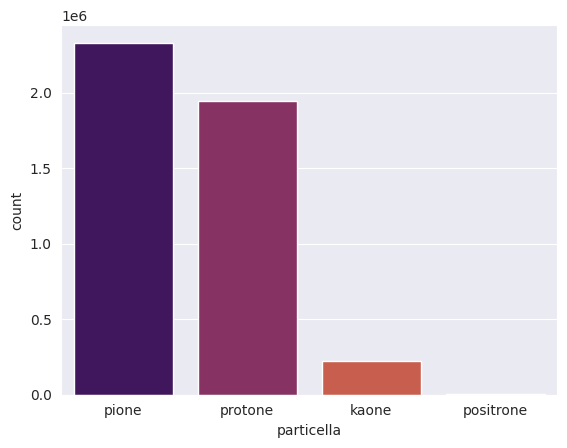

In [10]:
with sns.axes_style("darkgrid"):
    sns.countplot(x = df['particella'],
                palette='inferno')

print(df['particella'].value_counts(normalize = True) * 100)

Come si può vedere i **positroni** e **kaoni** sono rispettivamente solo un $5\%$ circa e lo $0.16\%$, ossia sono classi *sottorappresentate*. Pertanto è necessario effettuare un **resampling** del dataset in maniera tale da rendere tutte le classi equirappresentate e non avere un dataset sbilanciato.

In particolare andremo ad effettuare un **undersampling**, attraverso l'oggetto `RandomUnderSampler` offerto dalla libreria [`imbalanced Learn`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html).

In [11]:
# Mostro il numero di particelle per ciascuna classe 
sp = df['particella'].value_counts()
print(sp)

pione        2332465
protone      1945457
kaone         225613
positrone       7304
Name: particella, dtype: int64


In [12]:
from imblearn.under_sampling import RandomUnderSampler

In [13]:
# Resampling - Undersampling
x = pd.DataFrame(df)
y = x['particella']

undersample = RandomUnderSampler(sampling_strategy='not minority')
df_us, _ = undersample.fit_resample(x, y)

kaone        7304
pione        7304
positrone    7304
protone      7304
Name: particella, dtype: int64


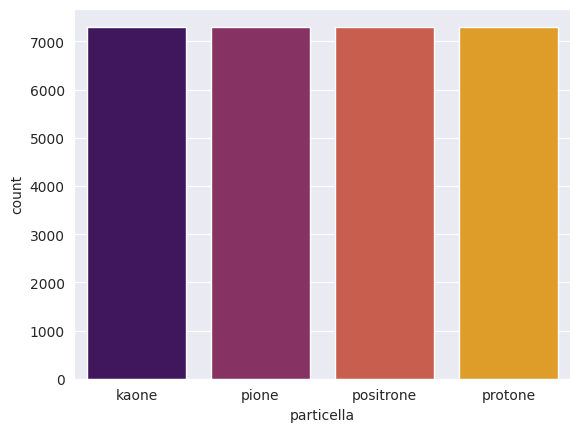

In [14]:
# Mostro il nuovo numero di particelle per ciascuna classe
print(df_us['particella'].value_counts())

with sns.axes_style("darkgrid"):
    sns.countplot(x = df_us['particella'],
                palette='inferno')

In [15]:
print("Numero di Particelle nel DataSet Iniziale: {}\n".format(df.shape[0]))
print("Numero di Particelle nel DataSet Finale: {}\n".format(df_us.shape[0]))
print("Il DataSet è stato ridotto del {:.2%}".format((df.shape[0]-df_us.shape[0])/df.shape[0]))

Numero di Particelle nel DataSet Iniziale: 4510839

Numero di Particelle nel DataSet Finale: 29216

Il DataSet è stato ridotto del 99.35%


Ora che il dataset è bilanciato, vedo se c'è qualche correlazione tra le feature mediante una [matrice di correlazione](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).


<AxesSubplot:>

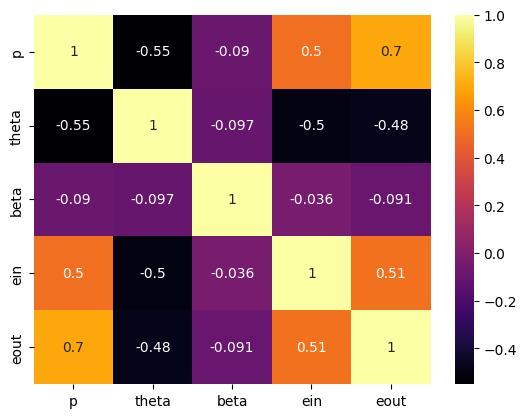

In [16]:
sns.heatmap(df_us.corr(method="spearman"), annot = True, cmap="inferno")

L'unica correlazione significativa che posso individuare è tra la *quantità di moto* e l'*energia in uscita*: fisicamente ciò è coerente, poichè le particelle più veloci sono anche le più energetiche.


Considerando il **$\beta$** e **$p$** invece, sicuramente non ho una correlazione lineare, ma osservo in che rapporto sono tra loro, poichè so teoricamente che la velocità relativistica è legata all'impulso come segue:

$$\beta=\sqrt{1+\frac{m^2c^2}{p^2}}\Longleftrightarrow y=\sqrt{1+\frac{A}{x^2}}$$

Dove **$A$** è un parametro strettamente legato alla massa della particella.

Pertanto dalla figura sottostante è facile capire come è possibile distinguere le particelle in base alla loro **massa**.

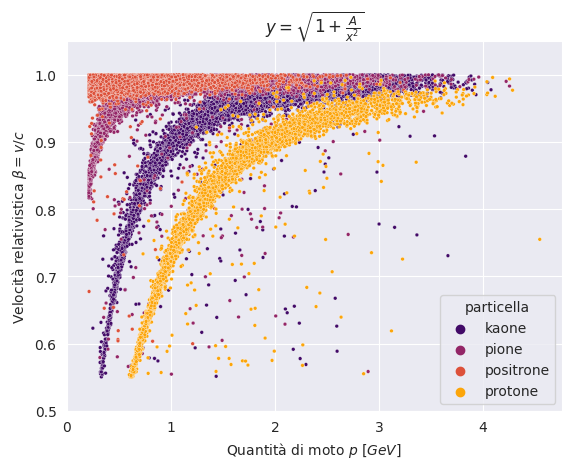

In [17]:
with sns.axes_style("darkgrid"):
    sns.scatterplot(
        data=df_us,
        x='p',
        y='beta',
        hue='particella',
        s = 7,
        palette = 'inferno'
        ).set(xlabel='Quantità di moto $p$ $[GeV]$',
              ylabel='Velocità relativistica $\\beta=v/c$',
              title = "$y=\sqrt{1+\\frac{A}{x^2}}$ ",
              ylim = (0.5,1.05))

Ricordando le masse delle particelle ho che:

$$m_{e^+} < m_{\pi} < m_{K} < m_{p}$$

Il comportamento delle diverse particelle è distinguibile in base alle loro masse: infatti, i *positroni* che sono i leptoni *più leggeri* sono prossimi al limite relativistico ($\beta\approx1$), mentre i *protoni* che sono gli adroni *più pesanti* sono presenti nella parte inferiore del plot.

Mi creo adesso una funzione che mi faccia comprendere visivamente come le particelle si distribuiscono rispetto le loro features.

Per fare questo utilizzo un **kernel density estimition plot KDE** di facile interpretazione, `sns.kdeplot()`. Analogalmente potevo usare anche `sns.displot(kind = "kde")`.

In [18]:
def distribuzione(colonna, target = 'particella'):
    for tag in df_us[target].unique(): #Plotto un grafico per ogni tipo di particella
        with sns.axes_style("darkgrid"):
            sns.kdeplot(data=df_us[df_us[target] == tag][colonna], label = tag, palette = 'inferno')
    with sns.axes_style("darkgrid"):
        sns.kdeplot(data=df_us[colonna],label = "Tutte", fill = True, palette = 'inferno')
    plt.legend()

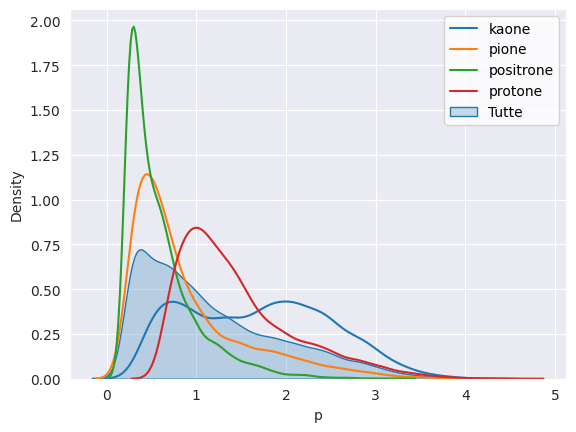

In [19]:
distribuzione('p')

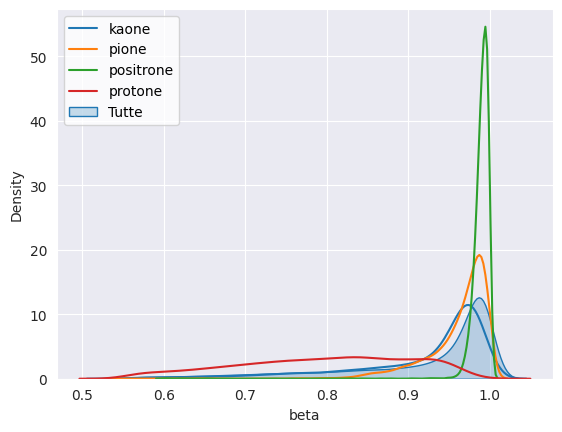

In [20]:
distribuzione('beta')

Come ci si aspettava le varie features non sono distribuite normalmente, ma gli algoritmi di cui faremo uso non sono fortemente influenzati dalla normalizzazione dei dati numerici.

## **Costruzione dei modelli & Addestramento**

Effettuata la pulizia dei dati, passiamo ora alla *creazione* e *addestramento* dei modelli di apprendimento. In particolare faremo uso di modelli di addestramento supervisionato per la classificazione come il **Decision Tree**, **Random Forest**, **Multilayer Perceptron** e **K-Nearest Neighbor**. Inoltre l'efficienza dei modelli verrà valutata mediante una **matrice di confusione** e l'**accuratezza**.

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

Comincio col suddividere il dataset per il *training* e il *test*, scegliendo l'$80\%$ del dataset per l'addestramento.

L'attributo `random_state` è per la riproducibilità del test.

In [22]:
x = df_us.drop(columns = ['particella']) # Le features ovviamente sono tutte quelle tranne il nome della particella
y = df_us['particella'] # label

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2022, train_size = 0.8)

### **Albero Decisionale**

Come primo modello uso un [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), lasciando i parametri di default. In generale **alberi decisionali** creano un modello che predice una classe o un valore in output a partire da regole di tipo *binario* inferite dalle *feature* dei dati.

In [23]:
dt_class = DecisionTreeClassifier(random_state=2022)
dt_class.fit(x_train, y_train)
y_pred_dt = dt_class.predict(x_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

Per valutarne l'efficienza uso una `ConfusionMatrixDisplay`, mostrando in che percentuale ciascuna label è stat predetta e considero anche l'`accuracy_score`:

Accuratezza DecisionTree:
89.61%


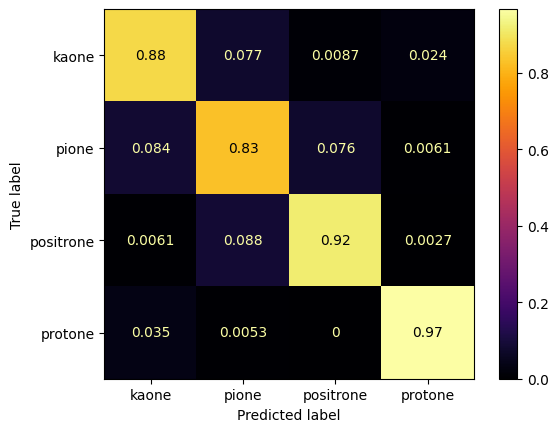

In [24]:
print('Accuratezza DecisionTree:\n{:.2%}'.format(dt_accuracy))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred_dt,
                                        cmap='inferno',
                                        normalize = 'pred')

### **Random Forest**

Come secondo modello uso un [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), cambiando i parametri `n_estimators` e `n_jobs`.

Il primo varia il numero di '*alberi nella foresta*', il secondo è puramente per sfruttare tutta la CPU.

Infatti un Random Forest è un **metodo ensemble** basato su *alberi decisionali*. Ossia combina diversi algoritmi, ottenendo in generale risultati migliori. In particolare, ogni *albero della foresta* è modellato su un sottoinsieme di dati e feature presenti nel set di training.

I risultati provenienti da ciascuno degli alberi saranno poi *mediati e combinati*, ottenendo un risultato generalmente migliore del singolo albero.

In [25]:
rf_class = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=2022)
rf_class.fit(x_train, y_train)
y_pred_rf = rf_class.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

Anche in questo caso, uso per valutarne l'efficienza uso una `ConfusionMatrixDisplay` e l'`accuracy_score`:

Accuratezza RandomForest:
93.19%


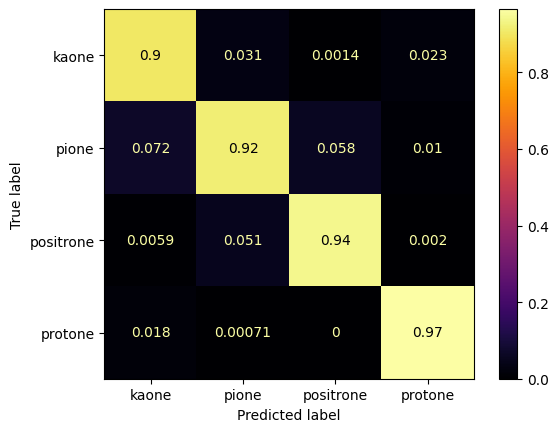

In [26]:
print('Accuratezza RandomForest:\n{:.2%}'.format(rf_accuracy))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred_rf,
                                        cmap='inferno',
                                        normalize = 'pred')

In questo caso però, valuto anche l'**importanza delle features** associata dal modello per la classificazione delle particelle.

Per farlo utilizzo l'attributo `feature_importances_` e ne visualizzo i risultati mediante un *barplot*.

In [27]:
importanza = pd.DataFrame(data={'Feature': x_train.columns,
                                'Importanza': rf_class.feature_importances_})
importanza.head()

,Feature,Importanza
0,p,0.335073
1,theta,0.056504
2,beta,0.436705
3,ein,0.107894
4,eout,0.063823


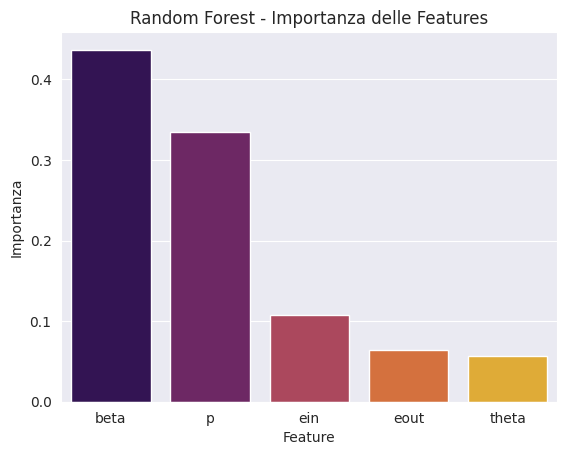

In [28]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = importanza,
                x=importanza['Feature'],
                y=importanza['Importanza'], 
                order = importanza.sort_values('Importanza',ascending = False).Feature, 
                palette = 'inferno').set(title = "Random Forest - Importanza delle Features")

Come si può vedere le features maggiormente importanti per l'addestramento del modello e la successiva predizione, sono la *quantità di moto $p$* e la *velocità relativistica $\beta$*. Ciò era prevedibil dal plot cinematico precedente, attaverso il quale è possibile distinguere, e quindi classificare, le varie particelle.

### **Multilayer Perceptron**

Come terzo modello uso un [`MLPclassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Un **Multilayer Perceptron** è il più semplice modello di **rete neurale** che è possibile concepire. Nella pratica, è un algoritmo che considera una relazione del tipo:

$$f:\mathbb{R}^5\to\mathbb{R}^4$$

Il *layer di imput* è costituito nel nostro caso da $5$ *neuroni*, mentre quello di *output* da $4$, nel mezzo ci sono i *layers nascosti*. Ogni neurone nel layer nascosto trasforma i valori del layer precedente con una sommatoria pesata seguita da una *funzione di attivazione* (`logistic`, `tanh`, `relu`).

Per la scelta dei parametri, in questo caso utilizzo una tecnica di **ottimizzazione degli iperparametri**, mediante l'oggetto  [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

La *grid search* prova ad eseguire l'algoritmo sui dati di training per ogni combinazione di parametri all'interno di una griglia data, fino a trovarne la migliore possibile.

In [29]:
griglia_parametri = [
    
        {
            'activation' : ['logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [(1,),(5,),(10,),(100,)]
        }
       ]

In [30]:
mlp_class = MLPClassifier(max_iter=300, random_state=2022)
mlp_upgrade = GridSearchCV(mlp_class, griglia_parametri, n_jobs=-1)
mlp_upgrade.fit(x_train, y_train)

print("I migliori parametri per il MLPClassifier sono:\n{}\n".format(mlp_upgrade.best_params_))

y_pred_mlp = mlp_upgrade.predict(x_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)


I migliori parametri per il MLPClassifier sono:
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}



c:\Users\Marco Cecca\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Anche in questo caso uso per valutarne l'efficienza uso una `ConfusionMatrixDisplay` e l'`accuracy_score`:

Accuratezza RandomForest:
93.05%


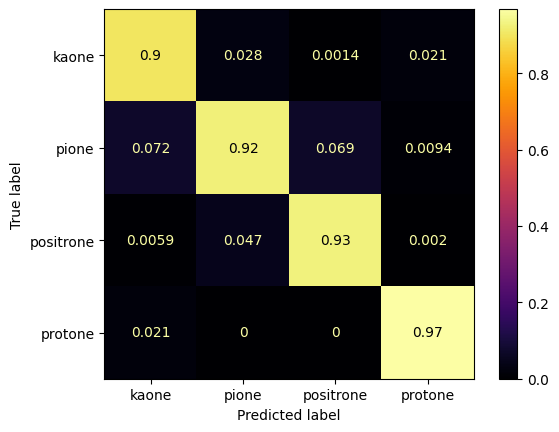

In [31]:
print('Accuratezza RandomForest:\n{:.2%}'.format(mlp_accuracy))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred_mlp,
                                        cmap='inferno',
                                        normalize = 'pred')

### **K-Nearest Neighbor(KNN)**

Come quarto e ultimo modello considero il [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Quest'ultimo classificatore si basa sull'*algoritmo KNN* che utilizza la *prossimità* per effettuare classificazioni sul raggruppamento di un singolo punto dati. In parole semplici, questo algoritmo pensa che più le cose sono vicine tra loro, più sono simili.

La *distanza* viene valutata tra il punto in esame e i **K punti** più vicini mediante diverse metriche, tra cui quella che useremo noi, ossia quella di default, la [`distanza di Minkowski`](https://it.wikipedia.org/wiki/Distanza_di_Minkowski).

In [33]:
knn_class = KNeighborsClassifier()
knn_class.fit(x_train, y_train)
y_pred_knn = knn_class.predict(x_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

Uso sempre una `ConfusionMatrixDisplay` e l'`accuracy_score`:

Accuratezza K-Nearest Neighbor:
88.60%


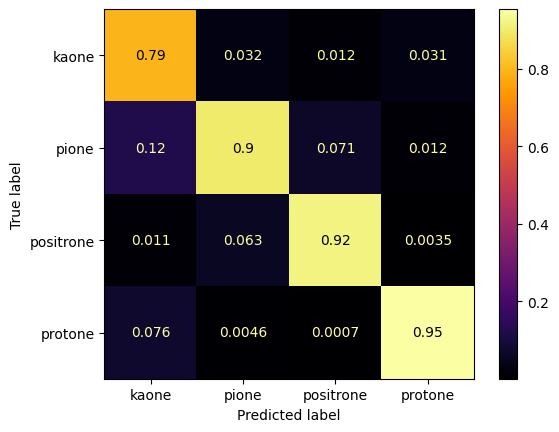

In [34]:
print('Accuratezza K-Nearest Neighbor:\n{:.2%}'.format(knn_accuracy))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred_knn,
                                        cmap='inferno',
                                        normalize = 'pred')

## **Confronto & Conclusione**

Concludo mettendo a confronto i modelli di classificazione testati attraverso la loro **accuratezza**

In [35]:
accuracy_vector = np.array([dt_accuracy, rf_accuracy, mlp_accuracy, knn_accuracy])
classificatori = np.array(['Decision Tree', 'Random Forest', 'ML Perceptron', 'K-Nearest Neighbor'])

df_acc = pd.DataFrame({"Classifier": classificatori,
                   "Accuracy": accuracy_vector})

,Classifier,Accuracy
0,Decision Tree,0.896133
1,Random Forest,0.931896
2,ML Perceptron,0.930527
3,K-Nearest Neighbor,0.886037


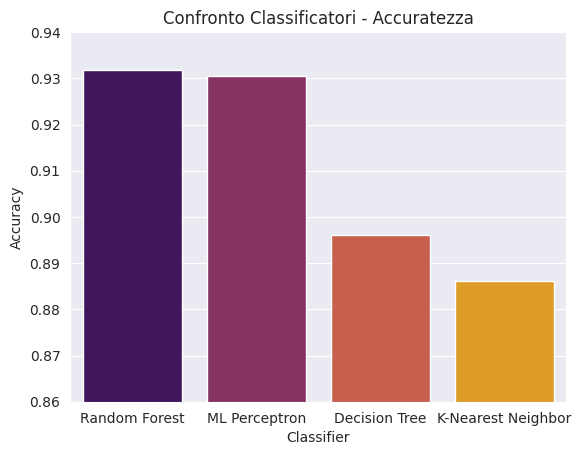

In [36]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = df_acc,
                x=df_acc['Classifier'],
                y=df_acc['Accuracy'], 
                order = df_acc.sort_values('Accuracy',ascending = False).Classifier, 
                palette = 'inferno').set(title = "Confronto Classificatori - Accuratezza",
                                        ylim=(0.86,0.94))
df_acc.head()

Da cui si può concludere, considerando l'accuratezza dei modelli, che si comportano tutti molto bene, ma il meno efficiente è il modello basato sull'algoritmo del *K-Nearest Neighbor*.